# [IAPR 2019:][iapr2019] Lab 1 ‒  Image segmentation

**Author:** Emiljano Gjiriti  
**Due date:** 04.04.2019

[iapr2019]: https://github.com/LTS5/iapr-2019

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [316]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

In [317]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
from scipy import ndimage
import cv2 as cv

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

### 1.1 Brain image visualization

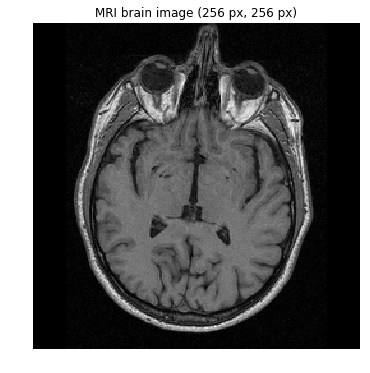

In [318]:
import skimage.io
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

In [319]:
def plot(data, title):
    """  
    Plotting Utility Function
    """
    plt.imshow(data)
    plt.gray()
    plt.title(title)

In [320]:
def count_area(im):
    """
    Measures the area of the brain
    """
    w,h = im.shape
    brain_area = 0
    # Note that a pixel in the image is accessed by its (y,x) coordinate
    for i in range(h):
        for j in range(w):
            if im[i][j] == 255:
                brain_area+=1
    
    return brain_area

### 1.2 Region growing
Add your implementation and discussion

In [321]:
def region_growing(img,i=100,j=100):
    """  
    Implementation of region growing method     
    Parameters: 
    img (numpy array): Source image
    i,j (int,int): Coordinates of the starting point which are entered manually by the user
    Returns: 
    Segmented Image
    """
    neighbors = [(0,1),(0,-1),(-1,0),(1,0)]
    intensity_thresh = 20
    width = img.shape[0]
    height = img.shape[1]    
    visited = []
    bfs_pixels = []
    seg = np.zeros((img.shape[0],img.shape[1]))
    if (i,j) in visited:
        return
    
    reg_els = 1
    reg_sum = img[i,j]
    bfs_pixels.append((i,j))

    while len(bfs_pixels) > 0:

        
        cur = bfs_pixels.pop(0)
        
        
        #print('cur is: ',cur[0],cur[1]) 
        if cur[0] < 0 or cur[0] >=height or cur[1]<0 or cur[1] >= width:
            continue
            
        if cur in visited or abs(img[cur[0],cur[1]] - reg_sum/reg_els) > intensity_thresh:
            #Intensity of the region should be within some thresh from the average intensity of the neighbors
            continue

        reg_els = reg_els + 1
        reg_sum = reg_sum + img[cur[0],cur[1]]
        seg[cur[0],cur[1]] = 255
        visited.append(cur)
        for nb in neighbors:
            bfs_pixels.append((cur[0]+nb[0],cur[1]+nb[1]))
    
    return seg

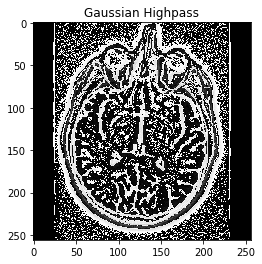

In [322]:
lowpass = ndimage.gaussian_filter(brain_im, 3)
gauss_highpass = brain_im - lowpass
#plot(ndimage.median_filter(gauss_highpass,15), r'Gaussian Highpass, $\sigma = 3 pixels$')
plot(gauss_highpass,'Gaussian Highpass')

In order to remove the 'salt and pepper' noise from the above image, we apply the median filter.

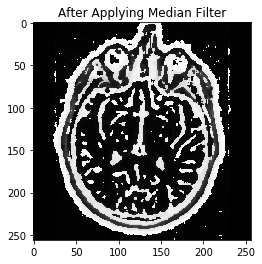

In [323]:
med_gauss_high = ndimage.median_filter(gauss_highpass,5)
plot(med_gauss_high,'After Applying Median Filter')

After applying the filters, it is much more clearer which part of the image consists the brain. We can also see that the brain is separated from the skull by a thick grey layers, so if we do region growing now, it will be able to segment the brain.

In [324]:
seg_img1 = region_growing(med_gauss_high)

/home/emiljano/anaconda3/envs/programming/lib/python2.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in ubyte_scalars


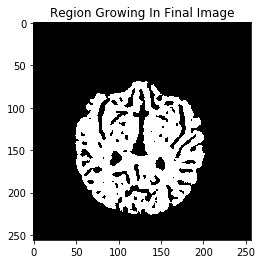

In [325]:
plot(seg_img1,'Region Growing In Final Image')

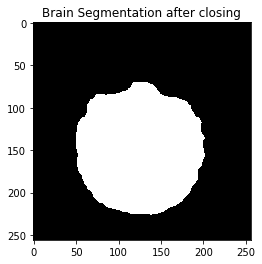

In [326]:
kern = cv.getStructuringElement(cv.MORPH_ELLIPSE,(18,18))
brain_close = cv.morphologyEx(seg_img1,cv.MORPH_CLOSE,kern)
plot(brain_close,'Brain Segmentation after closing')

In [327]:
print('Brain_area calculated from region growing = {0} pixels'
      .format(count_area(brain_close)))

Brain_area calculated from region growing = 18310 pixels


### 1.3 Contour detection
Add your implementation and discussion

In [328]:
import imutils
gray = brain_im
gray = cv.GaussianBlur(gray, (5, 5), 0)

#threshold the image
thresh = cv.threshold(gray, 60, 70, cv.THRESH_BINARY)[1]

# erode the image to remove small regions of noise
thresh = cv.erode(thresh, None, iterations=3)

# dilate the image to reinforce the contours(Little risk of noise dilation at this step)
thresh = cv.dilate(thresh, None, iterations=2)
 
# find contours in thresholded image, then grab the largest
# one
cnts = cv.findContours(thresh.copy(), cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
#cnts.remove(max(cnts, key=cv2.contourArea))
cnts = sorted(cnts,key = cv.contourArea)
c = cnts[-1]

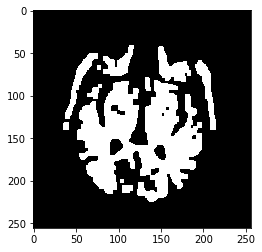

In [329]:
plt.imshow(thresh)

We have managed to extract most of the brain contours. We can now calculate the area of the brain by doing a closing with a large kernel.

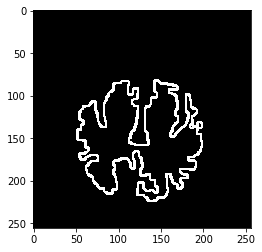

In [330]:
image = np.zeros((brain_im.shape[0],brain_im.shape[1]), np.uint8)
cv.drawContours(image, [c], -1, (255, 255, 255), 2)
plt.imshow(image)

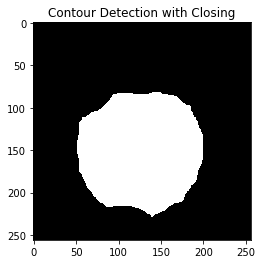

In [331]:
kern = cv.getStructuringElement(cv.MORPH_ELLIPSE,(70,70))
close = cv.morphologyEx(image,cv.MORPH_CLOSE,kern)
plot(close,'Contour Detection with Closing')

In [332]:
print('Brain area calculated from the contour method = {0}'.format((close == 255).sum()))

Brain area calculated from the contour method = 16951


### 1.4 Additional method(s)
Add your implementation and discussion

# Active Contours

We also tried the active contours method and found that it worked very well, although it took some trials to determine the best parameters (alpha,beta,gamma) and the starting point (125,145)

[0, 256, 256, 0]

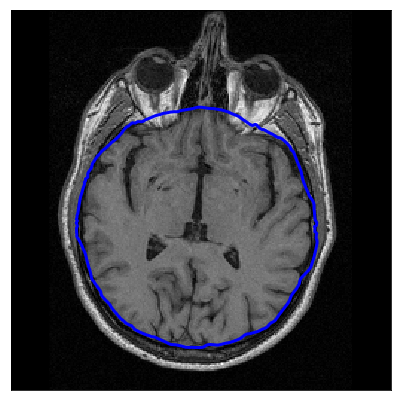

In [333]:
from skimage.segmentation import active_contour



img = brain_im

s = np.linspace(0, 2*np.pi, 400)
x = 125 + 80*np.cos(s)
y = 145 + 80*np.sin(s)
init = np.array([x, y]).T

snake = active_contour(img,
                       init, alpha=0.2, beta=0.01, gamma=0.01)

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(img, cmap=plt.cm.gray)
#ax.plot(init[:, 0], init[:, 1], '--r', lw=3)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img.shape[1], img.shape[0], 0])

Area of the brain is = 20390.0


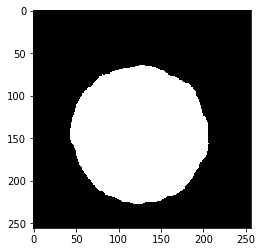

In [334]:

snake_int = snake.astype(int)
brain = cv.drawContours(np.zeros(brain_im.shape), [snake_int], 0, 1, -1)
print('Area of the brain is = {0}'.format(brain.sum()))
plt.imshow(brain)

## Part 2: Save the bees !

Varroa mites are recognized as the biggest pest to honey bees worldwide, and are believed to be the single largest contributing factor in the modern-day decline of honey bees due to their ability to transmit diseases, resulting in death or severe deformity of the pupae. 

Detecting and quantifying the presence of Verroa in a beehive is therefore crucial to treat the infection appropriately and as early as possible, and image analysis appears very useful in this problem.

![Varroa Mite](https://lts5www.epfl.ch/wp-content/uploads/2018/07/varroa-2.jpg)



### 2.1 Introduction to Project

You will find hereafter a set of 4 images taken under real conditions. In this task you will be ask to:
1. Count the number of Varroa on each picture
2. Determine the Intersection over Union of the detected patterns w.r.t. the ground truth
3. Estimate the Precision, Recall and F1-score at two different IoU thresholds $T = {0.5 \text{, and } 0.9}$


**Note** 

Try to have the same routine(s) running on the four images, and giving (approximatively) the same results. The routine(s) that you will write for this part will be useful for the final project as well, so pay special attention to it.

#### Vocabulary


* **IoU**: Let $A$ be the ground truth area and $B$ the predicted one. the intersection over union (IoU) is given as:
$$IoU(A,B) = \frac{A \cap B}{A \cup B} = \frac{\text{Area of Overlap}}{\text{Area of Union}}$$
Let $T$ be a scalar in the interval $[0, 1]$, then $B$ will be considered as a true positive (TP) if and only if $IoU(A,B) \ge T$. As a results, we can evaluate the performance of our detection with different values of $T$. The larger $T$ is, the more constraining is our condition.


* **Precision**: The precision is given as:
$$precision = \frac{tp}{tp + fp}$$
where $tp$ is the number of true positives and $fp$ the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.


* **Recall**: The recall is given as:
$$precision = \frac{tp}{tp + fn}$$
where $tp$ is the number of true positives and $fn$ the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.


* **F1-score**: The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:
$$F1 = \frac{2 \cdot precision \cdot recall}{precision + recall}$$


**FAQ**

Q: What to do if I have multiple ground truth $A_i$ and candidates $B_j$ and want to find the best set $(i,j)$ such that $(i, j) = \arg\max_{i,j} IoU(A_i, B_j)$ ? 

A: Here, we recommend to use a brute force approach. It corresponds to compute $IoU(A, B)$ for every possible pairs (i,j) and keep the pair with the highest $IoU$. Note that a candidate $B_j$ can **only** be matched to **one** ground truth area $A_i$.

### 2.2 Count the number of Varroa on each picture

Add your implementation and discussion

Hint: `skimage.measure.label` might be useful to label the thresholded image

Here, we visualize the 4 images for our patern detection

In [335]:
im_names = ['varroa-01', 'varroa-02', 'varroa-03', 'varroa-04']
filenames = [os.path.join(data_path, name) + '.jpg' for name in im_names]
ic = skimage.io.imread_collection(filenames)
print('Number of images: ', len(ic))

('Number of images: ', 4)


In [336]:
def plot_collection(fig_col,hist =  False):
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    for ax, im, nm in zip(axes.ravel(), fig_col, im_names):
        if hist:
            ax.hist(im.ravel(),256)
        else:
            ax.imshow(im)
        ax.axis('off')
        ax.set_title(nm)
    plt.show()

We can as well add the groud truth label that are stored in the corresponding XML files. Each xml file stores the position of the varroa on the image as :

```xml
<annotation>
	<object>
		<name>Varroa</name>
		<difficult>0</difficult>
		<bndbox>
			<xmin>14</xmin>
			<ymin>117</ymin>
			<xmax>33</xmax>
			<ymax>137</ymax>
		</bndbox>
	</object>
	<object>
		...
	</object>
	...
</annotation>
```
The block `object` defines the attributes of the varroa. `name` is the definition of the object class (always varroa). `bndbox` is the definition of the bounding box. To simplify your task, we implemented a function named `parse_file` that returns an array with the bounding box of the varroa expressed as `(x, y, width, heigth)` which corresponds to `(xmin, ymin, xmax-xmin, ymax-ymin)`

In [337]:
import xml.etree.ElementTree as ET

def parse_file(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text))-int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymax').text))-int(float(bbox.find('ymin').text))]
        objects.append(obj_struct)

    return objects


In [338]:
annotations_xmls = [parse_file(os.path.join(data_path, name) + '.xml') for name in im_names]

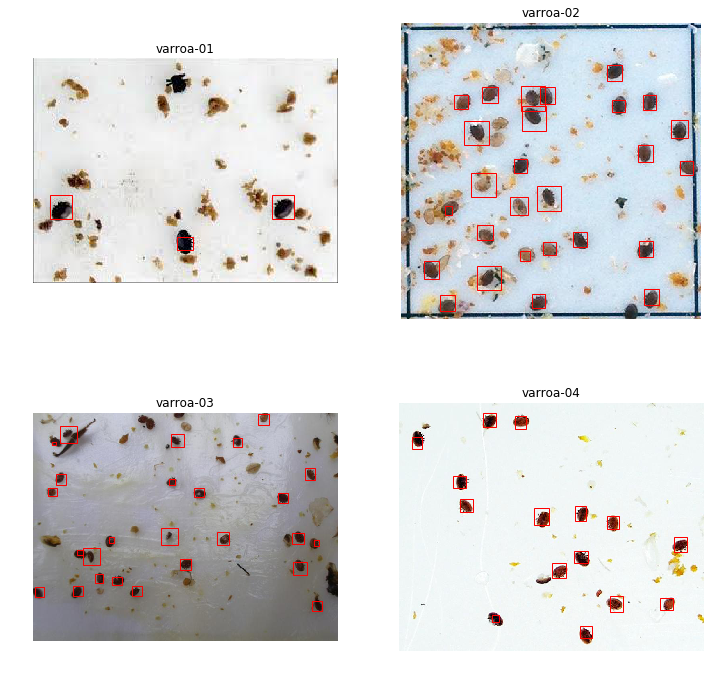

In [339]:
# Plot images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im, nm, annotations in zip(axes.ravel(), ic, im_names, annotations_xmls):
    # Iterate over annotations
    for anno in annotations:
        rect = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
                linewidth=1,edgecolor='r',facecolor='none')
       
        ax.add_patch(rect)
    
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

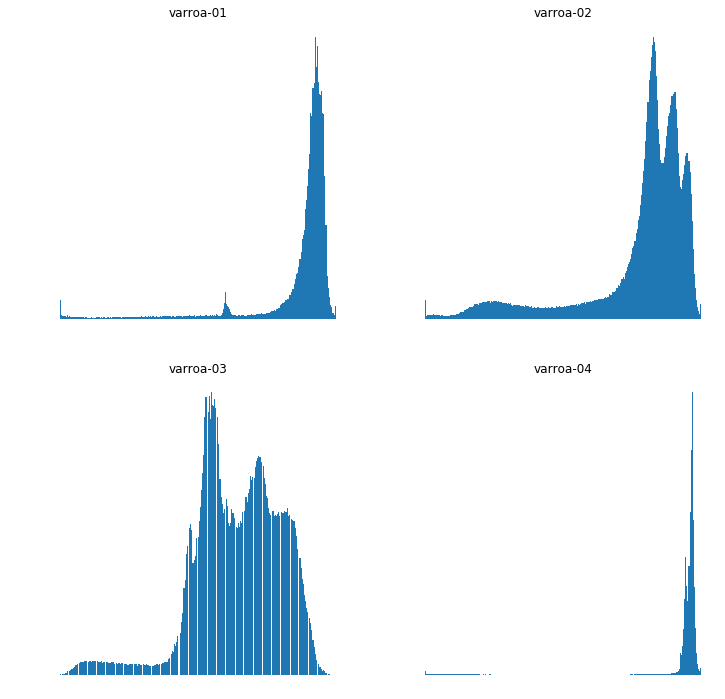

In [340]:
plot_collection(ic,True)

From the above plots, we notice that the histogram of the four pictures differ quite a bit. In order to have an algorithms which is as robust as possible, we tried to equalize the histogram of the pictures to the histogram of a single template picture. The template is chosen empirically by checking which choice gives the highest increase in precision. The idea behind histogram matching is that the cdf of the histogram of the source image must match the cdf of the histogram of the template image. Hence, in order to perform the histogram matching step, we fist calculate the cdf of both images and then we interpolate the values of the cdf of the source image from the cdf of the template image.

In [341]:
from skimage.exposure import cumulative_distribution

def cdf(im):
    """
    computes the CDF of an image as 2D numpy ndarray
    """
    c,b = cumulative_distribution(im)
    c = np.insert(c,0,[0]*b[0])
    return c

def hist_matching(c,c_t,im):
    """
    Input:
        c (numpy array): CDF of input image
        c_t (numpy array): CDF of template image
        im (numpy array): input image
    Returns:
        Modified image to match the histogram of template image
    """
    pixels = np.arange(256)
    new_pixels = np.interp(c,c_t,pixels)
    im = (np.reshape(new_pixels[im.ravel()],im.shape)).astype(np.uint8)
    return im

In [342]:
template = cdf(ic[3])
histogram_matched = []
for im in ic:
    res = hist_matching(cdf(im),template,im)
    histogram_matched.append(res)

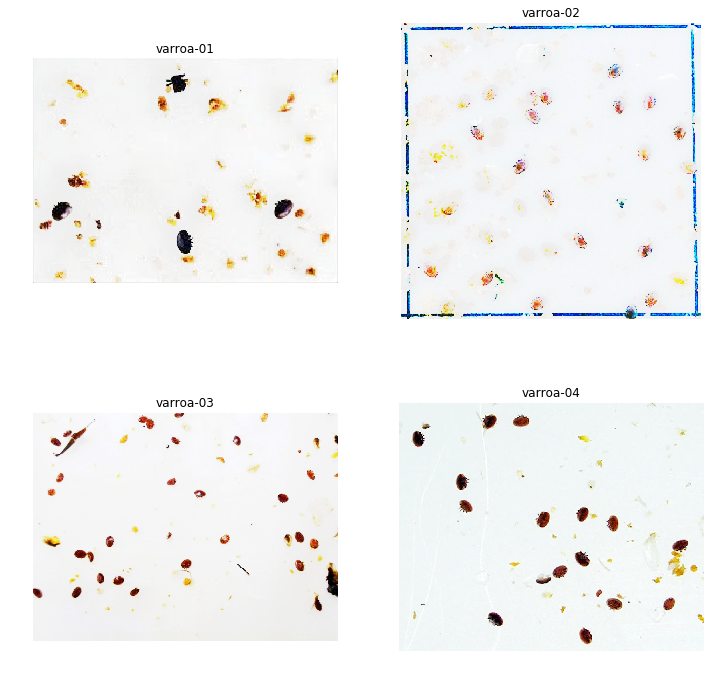

In [343]:
plot_collection(histogram_matched)

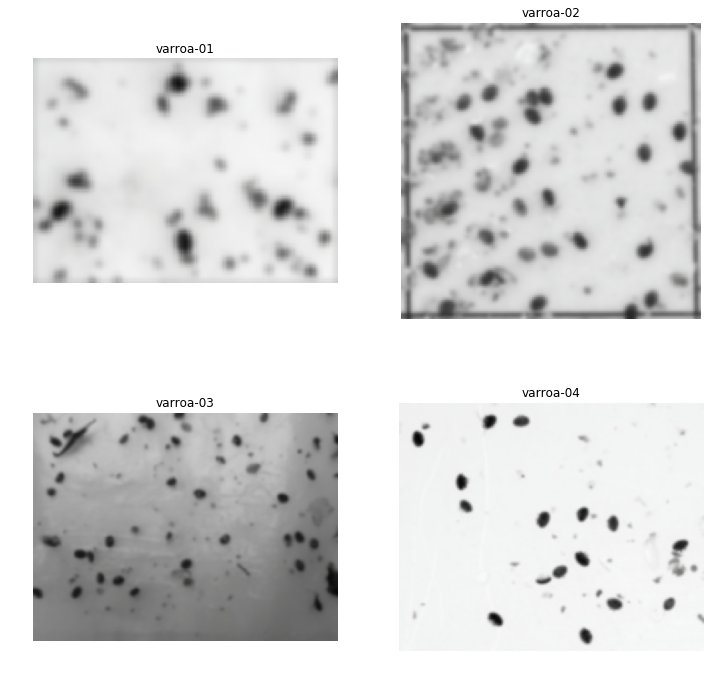

In [344]:
plot_collection(list(map(lambda im: ndimage.gaussian_filter(im,3),ic)))

In order to remove some of the noise, we used a gaussian filter with a kernel of small size 3 by 3, in order to not blurr the image to the point that it would be unable to detect the varroas. However, we observed that even with a kernel of small size, the density of high frequency pixels, which usually correspond to noise, is decreased considerably

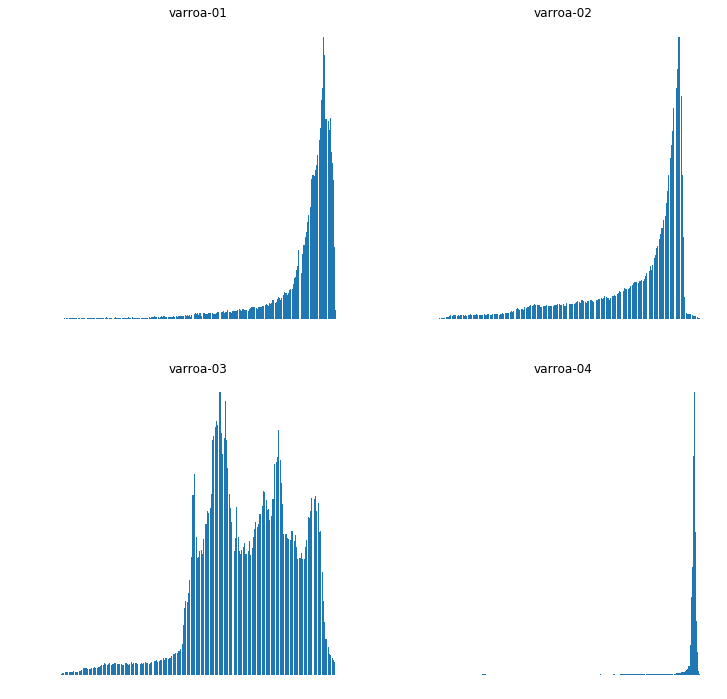

In [345]:
plot_collection(list(map(lambda im: ndimage.gaussian_filter(im,3),ic)),True)

In [346]:
thresholds,thresholds1 = [],[]
for im,im1 in zip(ic,histogram_matched):
    gauss_test = ndimage.gaussian_filter(im,3)
    gauss_test1 = ndimage.gaussian_filter(im1,3)
    ret,thresh = cv.threshold(gauss_test,80,200,cv.THRESH_BINARY_INV)
    # Erode to remove some of the noise
    thresh = cv.erode(thresh, None, iterations=3)
    # Dilate the remaining pixels (Little risk of dilating noise after erosion)
    thresh = cv.dilate(thresh, None, iterations=5)
    ret,thresh1 = cv.threshold(gauss_test1,120,200,cv.THRESH_BINARY_INV)
    # Erode to remove some of the noise
    thresh1 = cv.erode(thresh1, None, iterations=3)
    # Dilate the remaining pixels (Little risk of dilating noise after erosion)
    thresh1 = cv.dilate(thresh1, None, iterations=5)
    thresholds.append(thresh)
    thresholds1.append(thresh1)

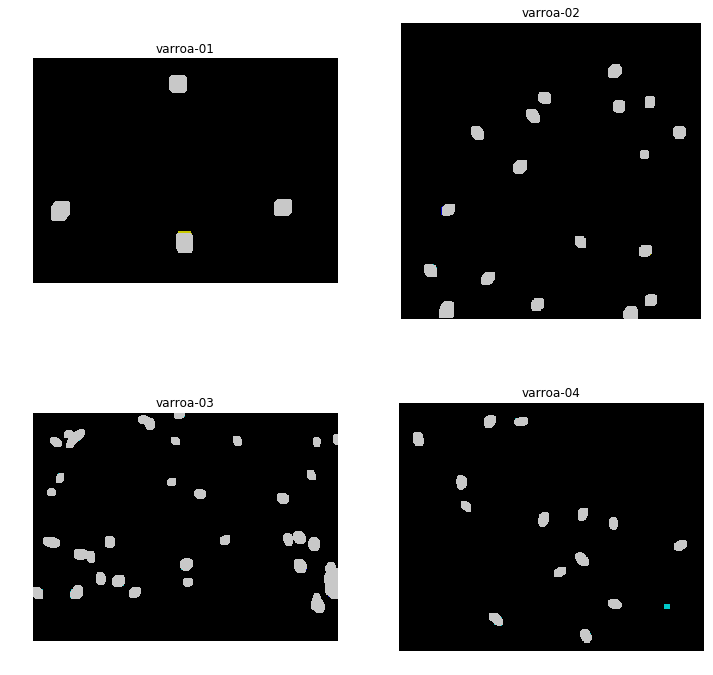

In [347]:
dilated_images = []
kern = cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3))
for thresh in thresholds:
    dilation = cv.dilate(thresh,kern,iterations = 1)
    dilated_images.append(dilation)
plot_collection(dilated_images)    

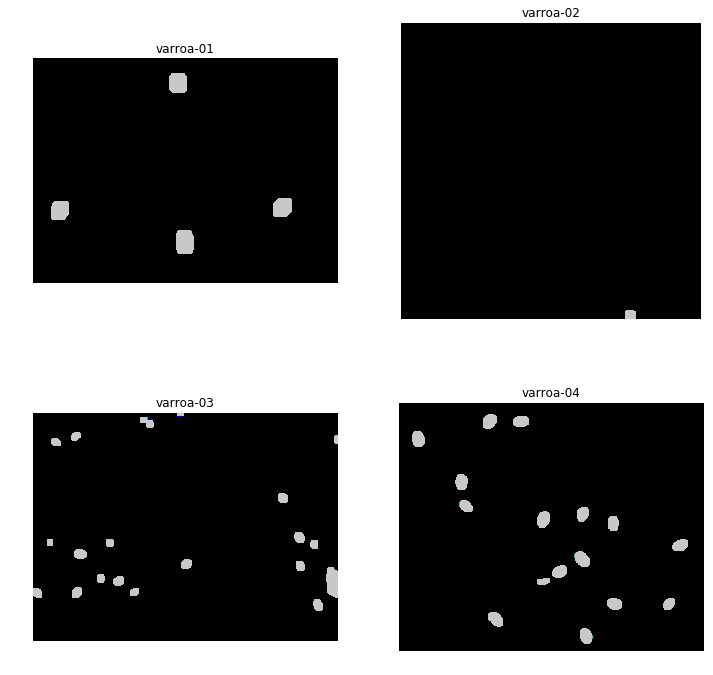

In [348]:
dilated_images1 = []
kern = cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3))
for thresh in thresholds1:
    dilation1 = cv.dilate(thresh,kern,iterations = 1)
    dilated_images1.append(dilation1)
plot_collection(dilated_images1)    

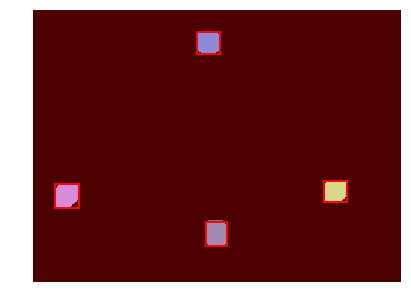

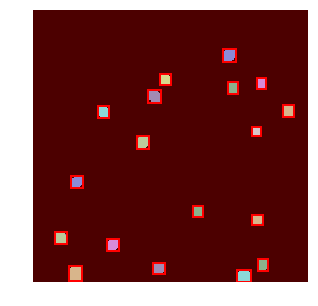

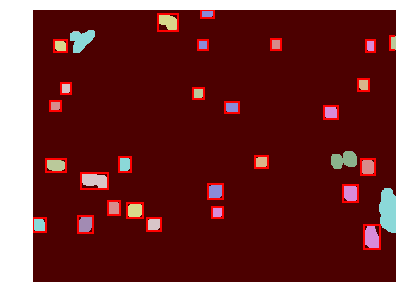

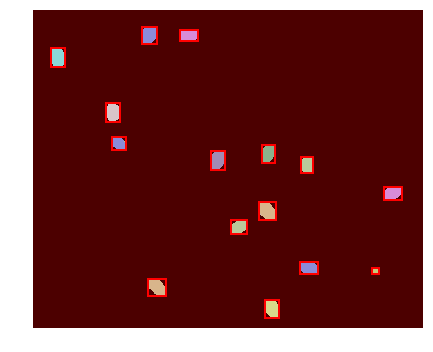

In [349]:
segmented_images = []
for dilation in dilated_images:
    dil = cv.cvtColor(dilation, cv.COLOR_BGR2GRAY)
    label_image = skimage.measure.label(dil)
    image_label_overlay = label2rgb(label_image, image=dil)

    fig, ax = plt.subplots(figsize=(7, 5))
    ax.imshow(image_label_overlay)

    for region in regionprops(label_image):
        # take regions with large enough areas
        if region.area <= 1000 and region.area>= 100:
            # draw rectangle around thresholded regions
            minr, minc, maxr, maxc = region.bbox
            rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                      fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

    ax.set_axis_off()
plt.tight_layout()
plt.show()

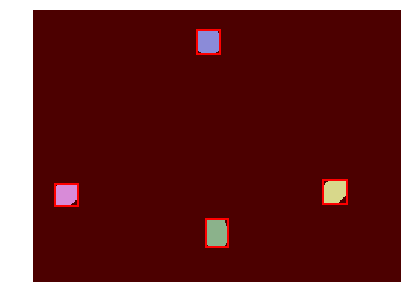

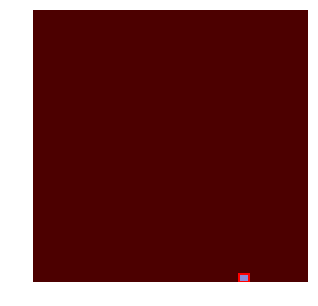

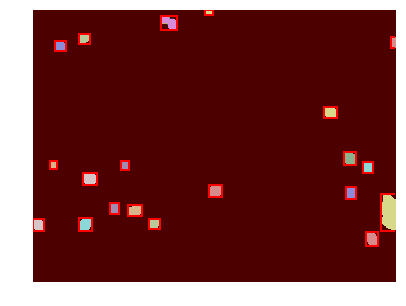

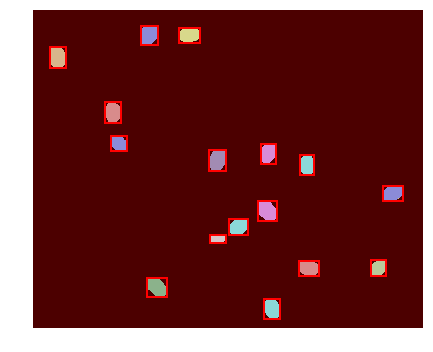

In [350]:
segmented_images = []
for dilation in dilated_images1:
    dil = cv.cvtColor(dilation, cv.COLOR_BGR2GRAY)
    label_image = skimage.measure.label(dil)
    image_label_overlay = label2rgb(label_image, image=dil)

    fig, ax = plt.subplots(figsize=(7, 5))
    ax.imshow(image_label_overlay)

    for region in regionprops(label_image):
        # take regions with large enough areas
        if region.area >= 100 and region.area <= 1500:
            # draw rectangle around thresholded regions
            minr, minc, maxr, maxc = region.bbox
            rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                      fill=False, edgecolor='red', linewidth=2)
            ax.add_patch(rect)

    ax.set_axis_off()
plt.tight_layout()
plt.show()

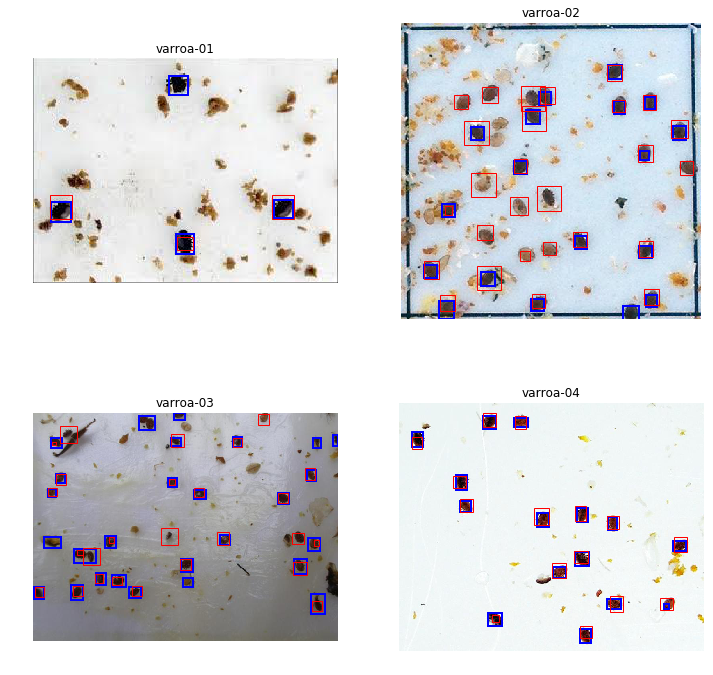

In [351]:
fig,axes = plt.subplots(2,2,figsize = (12,12))
kern = cv.getStructuringElement(cv.MORPH_ELLIPSE,(5,5))
for ax, im, annotations,dilation,nm in zip(axes.ravel(), ic,annotations_xmls,dilated_images,im_names):
    
    dil = cv.cvtColor(dilation, cv.COLOR_BGR2GRAY)
    label_image = skimage.measure.label(dil)
    regions = regionprops(label_image)
    
    for region in regions:
        #if region.area >= 70 and region.area <= 800:
            #print(region.area)
            # draw rectangle around segmented coins
        
        if region.area <=1000 and region.area >=100:
            minr, minc, maxr, maxc = region.bbox
            rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                      fill=False, edgecolor='blue', linewidth=2)
            ax.add_patch(rect)

    for anno in annotations:
        rect = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
                linewidth=1,edgecolor='r',facecolor='none')

        ax.add_patch(rect)

    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)

plt.show()

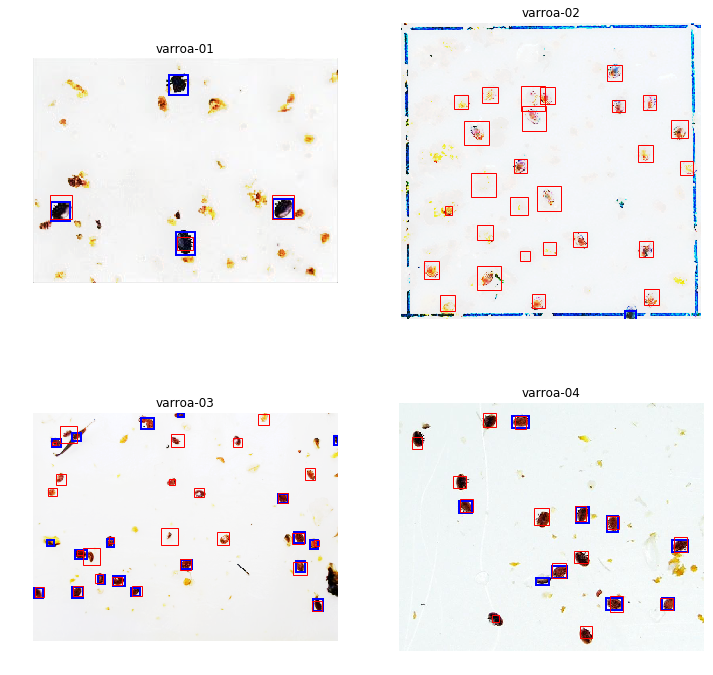

In [352]:
fig,axes = plt.subplots(2,2,figsize = (12,12))
kern = cv.getStructuringElement(cv.MORPH_ELLIPSE,(5,5))
for ax, im, annotations,dilation,nm in zip(axes.ravel(), histogram_matched,annotations_xmls,dilated_images1,im_names):
    
    dil = cv.cvtColor(dilation, cv.COLOR_BGR2GRAY)
    label_image = skimage.measure.label(dil)
    regions = regionprops(label_image)
    
    for region in regions:
        if region.area >= 100 and region.area <= 1000:
            #print(region.area)
            # draw rectangle around segmented coins
            minr, minc, maxr, maxc = region.bbox
            rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                      fill=False, edgecolor='blue', linewidth=2)
            ax.add_patch(rect)
    
    for anno in annotations:
        rect = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
                linewidth=1,edgecolor='r',facecolor='none')

        ax.add_patch(rect)

    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)

plt.show()


### 2.3 IoU of the detected pattern w.r.t. the ground truth

Add your implementation and discussion

Hint: `skimage.measure.regionprops` implements a large variety of descriptors

In [353]:
def is_corner_inside(x,y,bbox):
    
    """
    Checks if a corner is inside bounding box
    Parameters: 
    x (int): x coordinate of the corner
    y (int): y coordinate of the corner
    bbox (tuple): bounding box
  
    Returns: 
    boolean: True if the corner is inside the bounding box or false otherwise
  
    """
    if x >=bbox[0] and x<bbox[2] and y>=bbox[1] and y<bbox[3]:
        return True
    return False

In [354]:
def bbox_to_corners(bbox):
    """  
    Convert bounding box coordinates from (xmin,ymin,width,height) to (xmin,ymin,xmax,ymax)  
    Parameters: 
    bbox (list): bounding box 
  
    Returns: 
    list: bounding box with coordinates (xmin,ymin,xmax,ymax)
  
    """
    return [bbox[0],bbox[1],bbox[0]+bbox[2],bbox[1]+bbox[3]]

In [355]:
def find_intersection(bboxA,bboxB):
    """  
    Find area of intersection of two bounding boxes
    Parameters: 
    bboxA (list): first bounding box
    bboxB (list): second bounding box
  
    Returns: 
    int: Area of intersection of bounding boxes
  
    """
    dif1 = min(bboxA[2],bboxB[2]) - max(bboxA[0],bboxB[0])
    dif2 = min(bboxA[3],bboxB[3]) - max(bboxA[1],bboxB[1])
    if dif1 <= 0 or dif2 <= 0:
        return 0
    else:
        return dif1*dif2

In [356]:
def find_union(bboxA,bboxB):
    """  
    Find area of union of two bounding boxes
    Parameters: 
    bboxA (list): first bounding box
    bboxB (list): second bounding box
  
    Returns: 
    int: Area of union of bounding boxes as sum of areas - area of intersection
  
    """
    area1 = (bboxA[2]-bboxA[0])*(bboxA[3] - bboxA[1])  
    area2 = (bboxB[2]-bboxB[0])*(bboxB[3] - bboxB[1]) 
    return area1 + area2  - find_intersection(bboxA,bboxB)

In [357]:
def area_dif(bboxA,bboxB):
    """  
    Returns the difference in areas between two bounding boxes
    
    Parameters: 
    bboxA (list): first bounding box
    bboxB (list): second bounding box
  
    Returns: 
    int: difference in areas between the two bounding boxes
  
    """
    area1 = (bboxA[2] - bboxA[0]) * (bboxA[3] - bboxA[1])
    area2 = (bboxB[2] - bboxB[0]) * (bboxB[3] - bboxB[1])
    return area2 - area1

In [358]:
print(region.bbox)
print(anno['bbox'])
print(find_intersection(region.bbox,annotations_xmls[0][0]['bbox']))

(582L, 484L, 593L, 485L)
[385, 402, 33, 37]
0


In the first figure above, there is clearly overlap between the two rectangles. However the find_intersection method returns 0. As we can see, it appears to be a mismatch in coordinate labeling between the output of the regionprops method and the coordinates that we read from the XML file. In the regionprops output, 0 and 2 correspond to minY and maxY, while in the coordinates that we read from the XML file 0 and 2 correspond to minX and maxX. Hence, we fix the mismatch in the cell below

In [359]:
# Fix the mismatch between the coordinate labeling
all_regions,all_regions1 = [],[]
for dilation,dilation1 in zip(dilated_images,dilated_images1):
    dil = cv.cvtColor(dilation, cv.COLOR_BGR2GRAY)
    dil1 = cv.cvtColor(dilation1, cv.COLOR_BGR2GRAY)
    label_image = skimage.measure.label(dil)
    regions_tmp = regionprops(label_image)
    label_image1 = skimage.measure.label(dil1)
    regions_tmp1 = regionprops(label_image1)
    regions = []
    for r in regions_tmp:
        if r.area <= 1000 and r.area >=100:
            reg = list(r.bbox)
            reg[0],reg[1] = reg[1],reg[0]
            reg[2],reg[3] = reg[3],reg[2]
            regions.append(reg)
    all_regions.append(regions)
    regions = []
    for r in regions_tmp1:
        if r.area >= 100 and r.area<=1000:
            reg = list(r.bbox)
            reg[0],reg[1] = reg[1],reg[0]
            reg[2],reg[3] = reg[3],reg[2]
            regions.append(reg)
    all_regions1.append(regions)

In [360]:
ground_truths = []
for anotation in annotations_xmls:
    ground_truth = []
    for anot in anotation:
        ground_truth.append(bbox_to_corners(anot['bbox']))
    ground_truths.append(ground_truth)

Consider each (ground_truth, prediction) pair and store the one with the highest IoU

In [361]:
all_ratios,all_ratios1 = [],[]
for i in range(len(ground_truths)):
    ratios = []
    for region in all_regions[i]:
        max_iou,best_match_index = 0,-1
        for j in range(len(ground_truths[i])):
            iou = float(find_intersection(region,ground_truths[i][j]))/find_union(region,ground_truths[i][j])
            if iou > max_iou:
                best_match_index = j
                max_iou = iou
        ratios.append(max_iou)
    all_ratios.append(ratios)
    
for i in range(len(ground_truths)):
    ratios = []
    for region in all_regions1[i]:
        max_iou,best_match_index = 0,-1
        for j in range(len(ground_truths[i])):
            iou = float(find_intersection(region,ground_truths[i][j]))/find_union(region,ground_truths[i][j])
            if iou > max_iou:
                best_match_index = j
                max_iou = iou
        ratios.append(max_iou)
    all_ratios1.append(ratios)

### 2.4 Precision, Recall and F1-score at two different IoU thresholds

Add your implementation and discussion

In [362]:
#Calculate precision, recall and f1 for plain images without histogram equalization 
threshs = [0.5,0.9]
for i,ratios in enumerate(all_ratios):
    print('------Metrics for Figure '+str(i+1)+'--------')
    for thresh in threshs:
        fp,fn,tp,prec,recall,f1= [0.,0.,0.,0.,0.,0.,]
        for r in ratios:
            if r == 0:
                fp +=1
            if r>0 and r< thresh:
                fn +=1
            elif r>=thresh:
                tp +=1
        if tp == 0:
            prec,recall,f1 = [0,0,0]
        else:
            prec = tp/(tp+fp)
            recall = tp/(tp+fn)
            f1 = 2*prec*recall/(prec+recall)
        print('precision for threshold = {0} is {1}'.format(thresh,prec))
        print('recall for threshold = {0} is {1}'.format(thresh,recall))
        print('f1-score for threshold = {0} is {1}'.format(thresh,f1))

------Metrics for Figure 1--------
precision for threshold = 0.5 is 0.75
recall for threshold = 0.5 is 1.0
f1-score for threshold = 0.5 is 0.857142857143
precision for threshold = 0.9 is 0
recall for threshold = 0.9 is 0
f1-score for threshold = 0.9 is 0
------Metrics for Figure 2--------
precision for threshold = 0.5 is 0.875
recall for threshold = 0.5 is 0.411764705882
f1-score for threshold = 0.5 is 0.56
precision for threshold = 0.9 is 0
recall for threshold = 0.9 is 0
f1-score for threshold = 0.9 is 0
------Metrics for Figure 3--------
precision for threshold = 0.5 is 0.666666666667
recall for threshold = 0.5 is 0.571428571429
f1-score for threshold = 0.5 is 0.615384615385
precision for threshold = 0.9 is 0
recall for threshold = 0.9 is 0
f1-score for threshold = 0.9 is 0
------Metrics for Figure 4--------
precision for threshold = 0.5 is 1.0
recall for threshold = 0.5 is 0.733333333333
f1-score for threshold = 0.5 is 0.846153846154
precision for threshold = 0.9 is 0
recall for th

Below, we can see that histogram matching does not offer any increase in precision. We think that this happens, because given the differences in the histograms of the four images, trying to adjust the histogram of the other images to the histogram of one template, would significantly decrease the quality of the images.

In [363]:
#Calculate precision, recall and f1 for images with adjusted histogram
threshs = [0.5,0.9]
for i,ratios in enumerate(all_ratios1):
    print('------Metrics for Figure '+str(i+1)+'--------')
    for thresh in threshs:
        fp,fn,tp,prec,recall,f1 = [0.,0.,0.,0.,0.,0.,]
        for r in ratios:
            if r == 0:
                fp +=1
            if r>0 and r< thresh:
                fn +=1
            elif r>=thresh:
                tp +=1
        
        if tp == 0:
            prec = recall = f1 = 0
        else:
            prec = tp/(tp+fp)
            recall = tp/(tp+fn)
            f1 = 2*prec*recall/(prec+recall)
        print('precision for threshold = {0} is {1}'.format(thresh,prec))
        print('recall for threshold = {0} is {1}'.format(thresh,recall))
        print('f1-score for threshold = {0} is {1}'.format(thresh,f1))

------Metrics for Figure 1--------
precision for threshold = 0.5 is 0.666666666667
recall for threshold = 0.5 is 0.666666666667
f1-score for threshold = 0.5 is 0.666666666667
precision for threshold = 0.9 is 0
recall for threshold = 0.9 is 0
f1-score for threshold = 0.9 is 0
------Metrics for Figure 2--------
precision for threshold = 0.5 is 0
recall for threshold = 0.5 is 0
f1-score for threshold = 0.5 is 0
precision for threshold = 0.9 is 0
recall for threshold = 0.9 is 0
f1-score for threshold = 0.9 is 0
------Metrics for Figure 3--------
precision for threshold = 0.5 is 0.666666666667
recall for threshold = 0.5 is 0.533333333333
f1-score for threshold = 0.5 is 0.592592592593
precision for threshold = 0.9 is 0
recall for threshold = 0.9 is 0
f1-score for threshold = 0.9 is 0
------Metrics for Figure 4--------
precision for threshold = 0.5 is 0.888888888889
recall for threshold = 0.5 is 1.0
f1-score for threshold = 0.5 is 0.941176470588
precision for threshold = 0.9 is 0
recall for t

We perform a grid search to find the optimal parameters for the OpenCV functions. In our case, we're prioritizing precision, so we consider as the best parameters the ones that give the highest precision.

In [ ]:
# !!! Note: This function is only called offline, because it takes a lot of time to execute
'''
def gridsearch(hist = False):
    """
    Performs grid_search to find the best parameters for the OpenCV functions 
    """
    # Order: threshold_low, threshold_high,kernel_size,area_lim
    best_params = [0,0,0,0,0,0]
    best_prec = 0
    
    images = []
    if hist:
        images = histogram_matched
    
    else:
        images = ic
        
    for tu in range(200,255,10):
        for tl in range(50,100,10):
            for k in range(1,20):
                for m in range(4):
                    for n in range(6):
                        thresholds = []
                        for im in images:
                            gauss_test = ndimage.gaussian_filter(im,3)
                            ret,thresh = cv.threshold(gauss_test,tl,tu,cv.THRESH_BINARY_INV)
                            thresh = cv.erode(thresh, None, iterations=m)
                            thresh = cv.dilate(thresh,None,iterations =n)
                            thresholds.append(thresh)

                        dilated_images = []
                        kern = cv.getStructuringElement(cv.MORPH_ELLIPSE,(k,k))
                        for thresh in thresholds:
                            dilation = cv.dilate(thresh,kern,iterations = 1)
                            dilated_images.append(dilation)


                        all_regions = []
                        for dilation in dilated_images:
                            dil = cv.cvtColor(dilation, cv.COLOR_BGR2GRAY)
                            label_image = skimage.measure.label(dil)
                            regions_tmp = regionprops(label_image)
                            regions = []
                            for r in regions_tmp:
                                if r.area <= 1000 and r.area >=100:
                                    reg = list(r.bbox)
                                    reg[0],reg[1] = reg[1],reg[0]
                                    reg[2],reg[3] = reg[3],reg[2]
                                    regions.append(reg)
                            all_regions.append(regions)



                        all_ratios,all_ratios1 = [],[]
                        for i in range(len(ground_truths)):
                            ratios = []
                            for region in all_regions[i]:
                                max_iou,best_match_index = 0,-1
                                for j in range(len(ground_truths[i])):
                                    iou = float(find_intersection(region,ground_truths[i][j]))/find_union(region,ground_truths[i][j])
                                    if iou > max_iou:
                                        best_match_index = j
                                        max_iou = iou
                                ratios.append(max_iou)
                            all_ratios.append(ratios)

                        sum_prec = 0
                        for i,ratios in enumerate(all_ratios):
                            fp,fn,tp= [0.,0.,0.]
                            for r in ratios:
                                if r == 0:
                                    fp +=1
                                if r>0 and r< 0.5:
                                    fn +=1
                                elif r>=0.5:
                                    tp +=1

                            if tp+fp == 0:
                                continue

                            sum_prec += float(tp)/(tp+fp)
                            print('precision = {0}'.format(float(sum_prec)/4))

                        if float(sum_prec)/4 > best_prec:
                            best_prec = float(sum_prec)/4
                            best_params[0] = tl
                            best_params[1] = tu
                            best_params[2] = k
                            best_params[3] = m
                            best_params[4] = n
                            best_params[5 = best_prec

    return best_params

'''

In [365]:
#params = gridsearch()

After performing the grid search, we found that the parameters that gave the best result were low_threshold = 80, high_threshold = 200, kernel_size = 3 for an average precision of 82 %